In [169]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib import colormaps
import matplotlib.pyplot as plt
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts

In [170]:
beta_values = {}
sample_map = {}
patients_bothSamplesPure = {}
samples_from_purePairs = {}
figure_outdir = os.path.join('figures', 'multi-sample')
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [171]:
# Figure parameters

# scale factor
sf = 0.4

square_figsize = np.array([5, 4])
figsize = np.array([9, 7])
labelfontsize = 25
ticksfontsize = 18
opacity = 0.8
s = 50

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

## Primary-metastasis samples

In [172]:
proj_dir = os.path.join(consts['official_indir'], 'Reyngold')

sample_map['Reyngold'] = pd.read_table(os.path.join(proj_dir, 'sample_map.txt'), index_col=0)
patients_bothSamplesPure['Reyngold'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Reyngold'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Reyngold'] = sample_map['Reyngold'].index[sample_map['Reyngold']['unique patient id'].isin(patients_bothSamplesPure['Reyngold'])].values

In [173]:
correlation_df = pd.DataFrame(index=samples_from_purePairs['Reyngold'], columns=samples_from_purePairs['Reyngold'], data=float('nan'))
n_GSMs = correlation_df.shape[0]

for i in range(n_GSMs):
    GSM_i = samples_from_purePairs['Reyngold'][i]
    correlation_df.loc[GSM_i, GSM_i] = 1
    for j in range(i+1, n_GSMs):
        GSM_j = samples_from_purePairs['Reyngold'][j]
        ser_i = beta_values['Reyngold'][GSM_i]
        ser_j = beta_values['Reyngold'][GSM_j]
        res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
        if n_used >= 10:
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue

In [174]:
sample_map_copy = sample_map['Reyngold'][['unique patient id', 'sample type']].copy()
sample_map_copy['sample type'] = sample_map_copy['sample type'].map({'primary tumor':'Tum', 'lymph node metastasis':'Met'})
GSM_to_heatmap_label_mapper = sample_map_copy.loc[samples_from_purePairs['Reyngold']].apply(lambda x:': '.join(x), axis=1)
correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

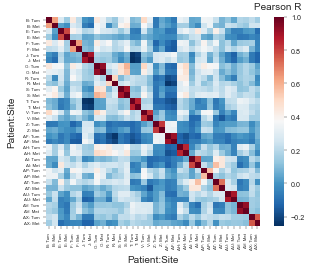

In [175]:
fig, ax = plt.subplots(figsize=square_figsize * 2.4 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df, cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.07)

ax.set_xlabel('Patient:Site', fontsize=labelfontsize * sf)
ax.set_ylabel('Patient:Site', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.yaxis.set_label_coords(-0.14, 0.5)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.6 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df.index)
ax.set_yticks(ticks, correlation_df.index)

fig.savefig(os.path.join(figure_outdir, 'prim-met_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [176]:
## Significant difference between between-patient correlations and same-patient correlations

same_patient_r = []
diff_patient_r = []

samples = correlation_df.index
n_samps = len(samples)
for i in range(n_samps - 1):
    samp_i = samples[i]
    patient_i = samp_i.split(':')[0]
    for j in range(i + 1, n_samps):
        samp_j = samples[j]
        patient_j = samp_j.split(':')[0]
        rvalue = correlation_df.loc[samp_i, samp_j]
        
        if patient_i == patient_j:
            same_patient_r.append(rvalue)
        else:
            diff_patient_r.append(rvalue)

pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue

print(f'Median within-patient correlation: {np.median(same_patient_r):.2f}')
print(f'Median between-patient correlation: {np.median(diff_patient_r):.2f}')
print(f'Wilcoxon rank sum test: P = {pvalue:.0e}')

Median within-patient correlation: 0.82
Median between-patient correlation: 0.14
Wilcoxon rank sum test: P = 5e-13


In [177]:
c_beta = 1 - beta_values['Reyngold'].std(axis=0)
c_beta_table_by_patient = sample_map['Reyngold'].reset_index().pivot(index='unique patient id', columns='sample type', values='index')
c_beta_table_by_patient['lymph node metastasis'] = c_beta_table_by_patient['lymph node metastasis'].map(c_beta)
c_beta_table_by_patient['primary tumor'] = c_beta_table_by_patient['primary tumor'].map(c_beta)

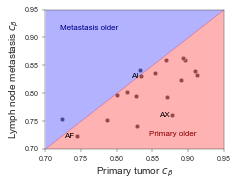

In [178]:
c_beta_table_by_patient = c_beta_table_by_patient.loc[patients_bothSamplesPure['Reyngold']]

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_table_by_patient.min().min()*0.95, c_beta_table_by_patient.max().max()*1.05)
pts_range = (0.7, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=c_beta_table_by_patient, x='primary tumor', y='lymph node metastasis', color='dimgray',
               s=s * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

ax.set_xlabel(ax.get_xlabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel().capitalize() + ' $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(pts_range[0]*1.03, pts_range[1]*0.96, 'Metastasis older',
        ha="left", va="bottom", fontfamily='sans-serif', color='darkblue',
        fontsize=labelfontsize * 0.8 * sf)
ax.text(pts_range[1]*0.96, pts_range[0]*1.03, 'Primary older',
        ha="right", va="bottom", fontfamily='sans-serif', color='darkred',
        fontsize=labelfontsize * 0.8 * sf)

for patient in ['AF', 'AX', 'AI']:
    xpos = c_beta_table_by_patient.loc[patient, 'primary tumor']
    ypos = c_beta_table_by_patient.loc[patient, 'lymph node metastasis']
    ax.text(xpos-0.003, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)

fig.savefig(os.path.join(figure_outdir, 'prim-met_age_comparison.pdf'), format='pdf', pad_inches=0.1)

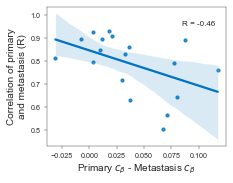

In [179]:
rvalue_list = [correlation_df.loc[f'{patient}: Tum', f'{patient}: Met'] for patient in patients_bothSamplesPure['Reyngold']]
rvalue_ser = pd.Series(index=patients_bothSamplesPure['Reyngold'], data=rvalue_list).rename('R')
c_beta_diff = (c_beta_table_by_patient['primary tumor'] - c_beta_table_by_patient['lymph node metastasis']).rename('c_beta_diff')

plot_data = pd.concat([rvalue_ser, c_beta_diff], axis=1)
R = epi_util.pearsonCorrelation(plot_data['c_beta_diff'], plot_data['R']).rvalue

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

sns.regplot(ax=ax, data=plot_data, x='c_beta_diff', y='R', color=consts['palette_jco'][0], scatter_kws={'s':s * 0.5 * sf})


ax.set_xlabel('Primary $c_β$ - Metastasis $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Correlation of primary\nand metastasis (R)', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(0.1, 0.95, f'R = {R:.2f}',
                        ha="center", va="bottom",
                        fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf)

fig.savefig(os.path.join(figure_outdir, 'prim-met_corr_vs_age_diff.pdf'), format='pdf', pad_inches=0.1)

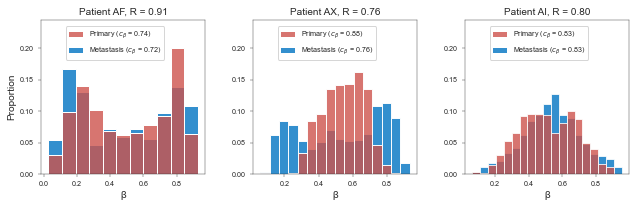

In [180]:
sf = 0.4

patient_list = ['AF', 'AX', 'AI']
#patient_list = patients_bothSamplesPure

nsamps = len(patient_list)
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows, ncols, figsize=figsize * [2.5, 1] * sf)
fig.tight_layout(pad=1)

color_dict = {'primary':consts['palette_jco'][3], 'metastasis':consts['palette_jco'][0]}

for i, patient in enumerate(patient_list):
    samp_prim = sample_map['Reyngold'].index[(sample_map['Reyngold']['unique patient id'] == patient) & (sample_map['Reyngold']['sample type'] == 'primary tumor')].values[0]
    samp_met = sample_map['Reyngold'].index[(sample_map['Reyngold']['unique patient id'] == patient) & (sample_map['Reyngold']['sample type'] == 'lymph node metastasis')].values[0]
    df_prim = beta_values['Reyngold'][samp_prim].rename('beta').to_frame()
    df_met = beta_values['Reyngold'][samp_met].rename('beta').to_frame()
    df_prim['sample type'] = 'primary'
    df_met['sample type'] = 'metastasis'
    df = pd.concat([df_prim, df_met], axis=0, ignore_index=True)
    
    col = i % ncols
    if nrows == 1:
        ax = axes[col]
    else:
        row = int(i / ncols)
        ax = axes[row, col]
        
#     legend = i == 0
    legend = False
    sns.histplot(ax=ax, data=df, x='beta', hue='sample type', common_norm=False, legend=legend, stat='proportion',
                 palette=color_dict, alpha=opacity)
    
    if i == 0:
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelfontsize * sf)
        
#         patches = [mpatches.Patch(color=color_dict[kind], label=kind.capitalize(),
#                                   alpha=opacity, linewidth=0)
#                    for kind in color_dict.keys()]
#         plots_x, plots_y = ax.get_position().get_points()[1]
#         fig.legend(handles=patches,
#            loc='center',
#            bbox_to_anchor=(0.19, 0.77),
#            fontsize=ticksfontsize * sf,
#            frameon=True
#           )
    else:
        ax.set_ylabel('')
    
    patches = [mpatches.Patch(color=color_dict['primary'], label=f'Primary ($c_β$ = {c_beta_table_by_patient.loc[patient, "primary tumor"]:.2f})',
                              alpha=opacity, linewidth=0),
               mpatches.Patch(color=color_dict['metastasis'], label=f'Metastasis ($c_β$ = {c_beta_table_by_patient.loc[patient, "lymph node metastasis"]:.2f})',
                              alpha=opacity, linewidth=0)]
    plots_x, plots_y = ax.get_position().get_points()[1]
    ax.legend(handles=patches,
       loc='center',
       bbox_to_anchor=(0.45, 0.85),
       fontsize=ticksfontsize * sf,
       frameon=True
      )
    
    rvalue = epi_util.pearsonCorrelation(df_prim['beta'], df_met['beta']).rvalue
    ax.set_xlabel('β', fontsize=labelfontsize * sf)
    ax.set_title(f'Patient {patient}, R = {rvalue:.2f}', fontsize=labelfontsize * sf)
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

    ax.set_ylim(0, 0.245)

fig.savefig(os.path.join(figure_outdir, 'prim-met-hists.pdf'), format='pdf', pad_inches=0.1)

In [181]:
sample_map['Reyngold']

,unique patient id,sample type
GSM1423637,A,primary tumor
GSM1423638,A,lymph node metastasis
GSM1423639,B,primary tumor
GSM1423640,B,lymph node metastasis
GSM1423641,E,primary tumor
...,...,...
GSM1423720,AY,lymph node metastasis
GSM1423721,AO,primary tumor
GSM1423722,AO,lymph node metastasis
GSM1423723,AZ,primary tumor


In [182]:
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0).squeeze('columns')
LUMP_purity_by_patient = sample_map['Reyngold'].reset_index().pivot(index='unique patient id', columns='sample type', values='index').loc[patients_bothSamplesPure['Reyngold']]
LUMP_purity_by_patient['primary tumor'] = LUMP_purity_by_patient['primary tumor'].map(LUMP_purity)
LUMP_purity_by_patient['lymph node metastasis'] = LUMP_purity_by_patient['lymph node metastasis'].map(LUMP_purity)

In [185]:
LUMP_diff = LUMP_purity_by_patient['lymph node metastasis'] - LUMP_purity_by_patient['primary tumor']
c_beta_diff = c_beta_table_by_patient['lymph node metastasis'] - c_beta_table_by_patient['primary tumor']

In [184]:
epi_util.pearsonCorrelation(LUMP_diff, c_beta_diff)

LinregressResult(slope=-0.32290610321252583, intercept=-0.02691722737234473, rvalue=-0.706301600240737, pvalue=0.0010519482937794444, stderr=0.08091047695111886, intercept_stderr=0.00711955197551758)

<Axes: ylabel='c_beta_diff'>

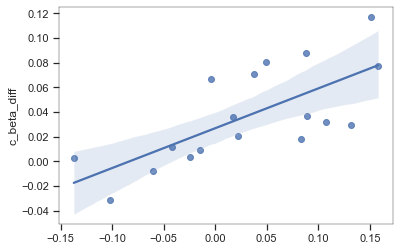

In [166]:
sns.regplot(x=LUMP_diff, y=c_beta_diff)

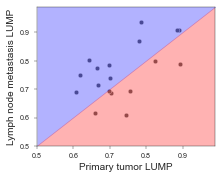

In [192]:
LUMP_purity_by_patient = LUMP_purity_by_patient.loc[patients_bothSamplesPure['Reyngold']]

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_table_by_patient.min().min()*0.95, c_beta_table_by_patient.max().max()*1.05)
pts_range = (0.5, 0.99)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=LUMP_purity_by_patient, x='primary tumor', y='lymph node metastasis', color='dimgray',
               s=s * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.fill_between(pts_range, pts_range, 1, alpha=0.3, color='blue', lw=0)
ax.fill_between(pts_range, 0, pts_range, alpha=0.3, color='red', lw=0)

ax.set_xlabel(ax.get_xlabel().capitalize() + ' LUMP', fontsize=labelfontsize * sf)
ax.set_ylabel(ax.get_ylabel().capitalize() + ' LUMP', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)


## Bifocal tumor samples

In [138]:
proj_dir = os.path.join(consts['official_indir'], 'Desmedt')

sample_map['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'sample_annotations_clean.txt'), index_col=0, dtype=str)
patients_bothSamplesPure['Desmedt'] = np.loadtxt(os.path.join(proj_dir, 'patients_bothSamplesPure.txt'), dtype=str)
beta_values['Desmedt'] = pd.read_table(os.path.join(proj_dir, 'beta_values_balanced_CpGs_pureSamples.txt'), index_col=0)
samples_from_purePairs['Desmedt'] = sample_map['Desmedt'].index[sample_map['Desmedt']['patient'].isin(patients_bothSamplesPure['Desmedt'])].values

In [139]:
correlation_df = pd.DataFrame(index=samples_from_purePairs['Desmedt'], columns=samples_from_purePairs['Desmedt'], data=float('nan'))
n_GSMs = correlation_df.shape[0]

for i in range(n_GSMs):
    GSM_i = samples_from_purePairs['Desmedt'][i]
    correlation_df.loc[GSM_i, GSM_i] = 1
    for j in range(i+1, n_GSMs):
        GSM_j = samples_from_purePairs['Desmedt'][j]
        ser_i = beta_values['Desmedt'][GSM_i]
        ser_j = beta_values['Desmedt'][GSM_j]
        res, n_used = epi_util.pearsonCorrelation(ser_i, ser_j, get_n_used=True)
        if n_used >= 10:
            correlation_df.loc[GSM_i, GSM_j] = res.rvalue
            correlation_df.loc[GSM_j, GSM_i] = res.rvalue

In [140]:
GSM_to_heatmap_label_mapper = sample_map['Desmedt'].loc[samples_from_purePairs['Desmedt'], ['patient', 'foci']].apply(lambda x:':'.join(x), axis=1)
correlation_df = correlation_df.rename(columns=GSM_to_heatmap_label_mapper).rename(index=GSM_to_heatmap_label_mapper)

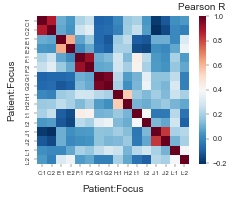

In [141]:
fig, ax = plt.subplots(figsize=square_figsize * 1.7 * sf)

cmap = colormaps['RdBu'].reversed()
cmap.set_bad('lightgray', 1.)
sns.heatmap(ax=ax, data=correlation_df, cmap=cmap, cbar_kws={'label':'Pearson R'})
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_size(labelfontsize * sf)
cbar_ax.tick_params(labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

cbar_ax.set_ylabel(cbar_ax.get_ylabel(), rotation=0)
cbar_ax.yaxis.set_label_coords(0.4, 1.09)

# ax.set_title('Cohort T3 Intrapatient Methylation Correlation', fontsize=20)
ax.set_xlabel('Patient:Focus', fontsize=labelfontsize * sf)
ax.set_ylabel('Patient:Focus', fontsize=labelfontsize * sf)
ax.xaxis.set_label_coords(0.5, -0.14)
ax.yaxis.set_label_coords(-0.14, 0.5)

ax.tick_params(axis='both', labelsize=ticksfontsize * 0.8 * sf, width=sf, length=8 * sf)
ticks = np.sort(np.concatenate([ax.get_xticks(), ax.get_xticks() + 1]))
ax.set_xticks(ticks, correlation_df.index)
ax.set_yticks(ticks, correlation_df.index)

fig.savefig(os.path.join(figure_outdir, 'bifocal_heatmap.pdf'), format='pdf', pad_inches=0.1)

In [142]:
## Significant difference between between-patient correlations and same-patient correlations

same_patient_r = []
diff_patient_r = []

samples = correlation_df.index
n_samps = len(samples)
for i in range(n_samps - 1):
    samp_i = samples[i]
    patient_i = samp_i.split(':')[0]
    for j in range(i + 1, n_samps):
        samp_j = samples[j]
        patient_j = samp_j.split(':')[0]
        rvalue = correlation_df.loc[samp_i, samp_j]
        
        if patient_i == patient_j:
            same_patient_r.append(rvalue)
        else:
            diff_patient_r.append(rvalue)

pvalue = epi_util.ranksums(same_patient_r, diff_patient_r).pvalue

print(f'Median within-patient correlation: {np.median(same_patient_r):.2f}')
print(f'Median between-patient correlation: {np.median(diff_patient_r):.2f}')
print(f'Wilcoxon rank sum test: P = {pvalue:.0e}')

Median within-patient correlation: 0.72
Median between-patient correlation: 0.10
Wilcoxon rank sum test: p = 3e-06


In [83]:
c_beta = 1 - beta_values['Desmedt'].std(axis=0)
c_beta_table_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index').loc[patients_bothSamplesPure['Desmedt']]
c_beta_table_by_patient['1'] = c_beta_table_by_patient['1'].map(c_beta)
c_beta_table_by_patient['2'] = c_beta_table_by_patient['2'].map(c_beta)

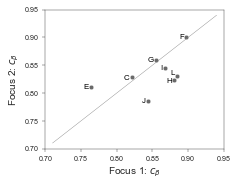

In [93]:
fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_table_by_patient.min().min()*0.98, c_beta_table_by_patient.max().max()*1.02)
pts_range = (0.7, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=c_beta_table_by_patient, x='1', y='2', color='dimgray', s=s * sf)

ax.set_xlabel('Focus 1: $c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Focus 2: $c_β$', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

offset_y = {'L':0.005}

for patient in c_beta_table_by_patient.index:
    xpos = c_beta_table_by_patient.loc[patient, '1']
    ypos = c_beta_table_by_patient.loc[patient, '2']
    if patient in offset_y:
        ypos += offset_y[patient]
    ax.text(xpos-0.003, ypos, patient,
            ha="right", va="center", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)

plt.savefig(os.path.join(figure_outdir, 'bifocal_age_comparison.pdf'), format='pdf')

In [90]:
LUMP_purity = pd.read_table(os.path.join(proj_dir, 'LUMP_purity.txt'), index_col=0).squeeze('columns')
LUMP_purity_by_patient = sample_map['Desmedt'].reset_index().pivot(index='patient', columns='foci', values='index').loc[patients_bothSamplesPure['Desmedt']]
LUMP_purity_by_patient['1'] = LUMP_purity_by_patient['1'].map(LUMP_purity)
LUMP_purity_by_patient['2'] = LUMP_purity_by_patient['2'].map(LUMP_purity)

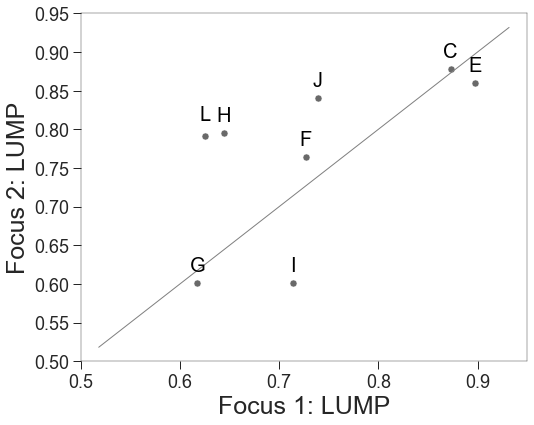

In [104]:
sf = 1

fig, ax = plt.subplots(figsize=square_figsize * 1.6 * sf)

# pts_range = (c_beta_table_by_patient.min().min()*0.98, c_beta_table_by_patient.max().max()*1.02)
pts_range = (0.5, 0.95)
pts_arr = np.linspace(pts_range[0], pts_range[1], 100)

sns.scatterplot(ax=ax, data=LUMP_purity_by_patient, x='1', y='2', color='dimgray', s=s * sf)

ax.set_xlabel('Focus 1: LUMP', fontsize=labelfontsize * sf)
ax.set_ylabel('Focus 2: LUMP', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.set_xlim(pts_range[0], pts_range[1])
ax.set_ylim(pts_range[0], pts_range[1])

ax.plot(pts_arr[4:-4], pts_arr[4:-4], color="grey", linestyle='solid', linewidth=1.0 * sf)

# offset_y = {'L':0.005}

for patient in LUMP_purity_by_patient.index:
    xpos = LUMP_purity_by_patient.loc[patient, '1']
    ypos = LUMP_purity_by_patient.loc[patient, '2']
    if patient in offset_y:
        ypos += offset_y[patient]
    ax.text(xpos, ypos+0.01, patient,
            ha="center", va="bottom", fontfamily='sans-serif', color='black',
            fontsize=labelfontsize * 0.8 * sf)


<Axes: xlabel='LUMP', ylabel='c_beta'>

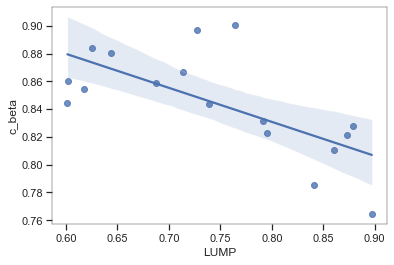

In [103]:
plot_data = pd.concat([LUMP_purity.rename('LUMP'), c_beta.rename('c_beta')], axis=1)

sns.regplot(data=plot_data, x='LUMP', y='c_beta')